# Denoising Score Matching(DSM) Notebook
- This notebook is for learning the DSM method and use this loss function to learn the distribution of the data.
- We will discuss the following topics:
    - One-step score matching
    - Score matching with different original distribution
    - Score matching in higher dimension
    - Score matching in a stochastic process
        - Ornstein-Uhlenbeck process
        - Sampling from Ornstein-Uhlenbeck process
    

# 0. Background Settings
This is the library we will use in this notebook

In [1]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax
import numpy as np
import random
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt

Random seed settings and key generator

In [2]:
seed = 0
rand_seed = random.randint(0, 1000000)
globe_key = jrandom.PRNGKey(rand_seed)
def key_gen():
    global globe_key
    new_key, subkey = jrandom.split(globe_key)
    globe_key = new_key
    return subkey


# 1. One-step score matching

In [3]:
def add_noise(key, x, sigma=0.1):
    key, subkey = jrandom.split(key)
    return x + sigma * jrandom.normal(subkey, x.shape)


class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x
    
    

In [4]:
def init_train_state_onestep(key, model, x) ->train_state.TrainState:
    params = model.init(key, x)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

@partial(jax.jit, static_argnums=(2,3))
def update_step(key, state, sigma, sample_size):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2))* 0.5 +1
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step(subkey,state, sigma, sample_size)
    if i % 1000 == 0:
        print(loss)
    
    

101.00396
103.810646
100.65158
93.28691
100.18856
93.07341
101.28311
87.25058
101.490166
100.64597


### Plot the learned distribution on the 2D plane
The red arrows are gradients of the learned distribution and the original distribution is a 2D Gaussian distribution.

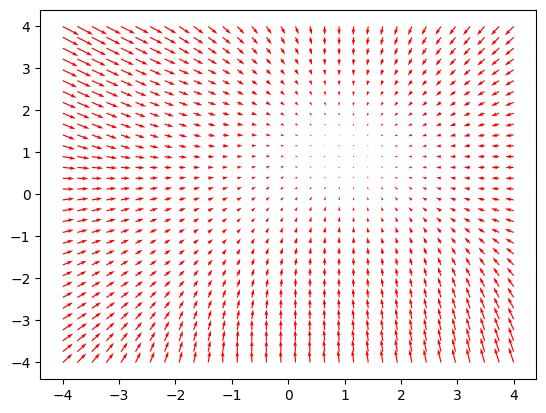

In [5]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
plt.show()

# 2. Score matching with different original distribution
People can use different original distribution to learn the distribution of the data. Here we will show the score matching method on different original distribution.

In [6]:
@partial(jax.jit, static_argnums=(2,3,4))
def update_step_mixture_gaussian(key, state, sigma, sample_size, num_mixture=2, mixture_weight=jnp.array([0.5, 0.5]), mixture_mean=jnp.array([-2, 2]), mixture_std=jnp.array([0.5, 0.5])):
    # test the sum of the mixture weight
    # assert jnp.sum(mixture_weight) == 1
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2)) * mixture_std[compoent] + mixture_mean[compoent]
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

In [7]:
model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_mixture_gaussian(subkey,state, sigma, sample_size, num_mixture=3, mixture_weight=jnp.array([0.8, 0.1, 0.1]), mixture_mean=jnp.array([-2, 2, 0]), mixture_std=jnp.array([0.5, 0.5, 0.5]))
    if i % 1000 == 0:
        print(loss)

103.28881
99.096146
97.61623
99.90662
95.15532
100.51211
98.61435
94.53272
92.58647
102.09263


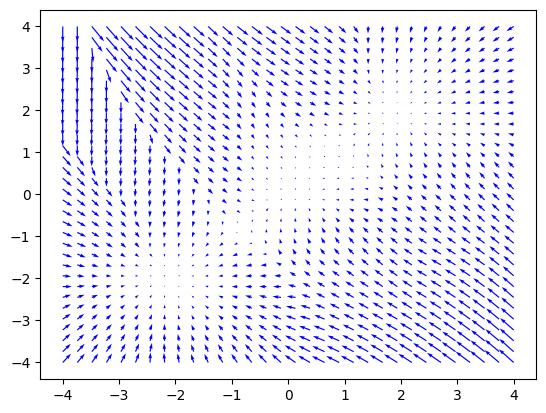

In [8]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

## 2.1 Sample given numbers of centers, std and mixture weight to generate the data

In [9]:
# sample the hyperparameters
def sample_hyperparameter(key, num_mixture=2):
    key, subkey = jrandom.split(key)
    mixture_weight = jrandom.dirichlet(subkey, jnp.ones(num_mixture))
    key, subkey = jrandom.split(key)
    mean_xs = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    mean_ys = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    stds = jrandom.uniform(subkey, (num_mixture, 2)) *1 + 0.5
    means = jnp.stack([mean_xs, mean_ys], axis=-1)
    return mixture_weight, means, stds, key

def sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight=None, means=None, stds=None):
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    stds = jnp.reshape(stds[compoent], (sample_size, 2))
    means = jnp.reshape(means[compoent], (sample_size, 2))
    print(stds)
    
    batch_x = jax.vmap(lambda mean, std: jnp.multiply(jrandom.normal(subkey, (2,)), std) + mean, in_axes=(0,0))(means, stds)
    return batch_x, mixture_weight, means, stds, key

@partial(jax.jit, static_argnums=(2,3,4))
def update_step_MG_random(key, state, sigma, sample_size, num_mixture, mixture_weight=jnp.array([0.5, 0.5]), means=jnp.array([[-2, 2], [2, -2]]), stds=jnp.array([[0.5, 0.5], [0.5, 0.5]])):
    batch_x, mixture_weight, means, stds, key = sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight, means, stds)
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
num_mixture = 2
mixture_weight, means, stds, subkey = sample_hyperparameter(subkey, num_mixture)
globe_key = subkey

for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_MG_random(subkey,state, sigma, sample_size, num_mixture, mixture_weight, means, stds)
    if i % 1000 == 0:
        print(loss)
    
print("Mixture weight: ", mixture_weight)
print("Mixture means: ", means)
print("Mixture stds: ", stds)
print("mixture covariance: ", jax.vmap(lambda std: jnp.diag(std**2), in_axes=(0))(stds))


Traced<ShapedArray(float32[500,2])>with<DynamicJaxprTrace(level=1/0)>
100.09421
105.38999
102.29599
104.80191
99.43946
101.35697
94.92475
99.18003
99.62143
104.57323
Mixture weight:  [0.8623313  0.13766871]
Mixture means:  [[[ 4.89542    0.3871193]]

 [[-3.2909298 -1.2681901]]]
Mixture stds:  [[1.3611714  0.81409764]
 [1.4024212  0.8585292 ]]
mixture covariance:  [[[1.8527875  0.        ]
  [0.         0.66275495]]

 [[1.9667853  0.        ]
  [0.         0.7370724 ]]]


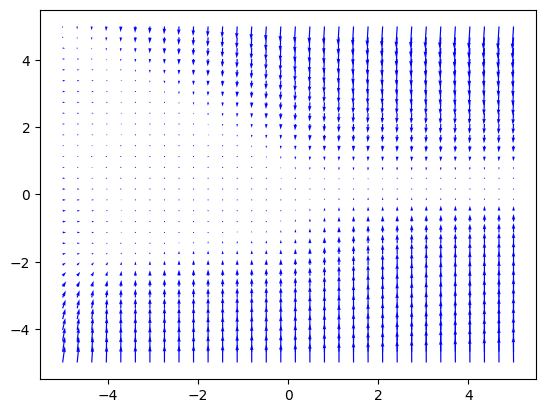

In [10]:
X, Y = jnp.meshgrid(jnp.linspace(-5, 5, 32), jnp.linspace(-5, 5, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()


## 2.2 Sample mixture gaussian that centers are on the circle

In [11]:
class MLP_for_circle(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x

In [12]:
@partial(jax.jit, static_argnums=(0,1))
def circle_points(num_points, radius):
    angles = jnp.linspace(0, 2*jnp.pi, num_points+1)[:-1]
    print(angles)
    x = radius * jnp.cos(angles)
    y = radius * jnp.sin(angles)
    return jnp.stack([x, y], axis=-1)

@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_GM_circle(key, state, sigma, sample_size, num_mixture, radius=2):
    means = circle_points(num_mixture, radius)
    mixture_weight = jnp.ones(num_mixture) / num_mixture
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    keys = jrandom.split(key, sample_size)
    # keys = keys[:,0]
    # keys = keys.reshape((sample_size, -1))
    batched_x = jax.vmap(lambda mean, single_key: jrandom.normal(single_key, (2,)) * 0.5 + mean, in_axes=(0, 0))(means[compoent], keys )
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batched_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batched_x, batch_noised_x), axis=0)
    
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = MLP_for_circle()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 800
num_mixture = 8
radius = 2
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_GM_circle(subkey,state, sigma, sample_size, num_mixture, radius)
    if i % 1000 == 0:
        print(loss)

Traced<ShapedArray(float32[8])>with<DynamicJaxprTrace(level=2/0)>
96.538826
98.57998
96.23539
95.034645
102.8875
96.29127
103.77836
96.56834
92.16958
100.240105


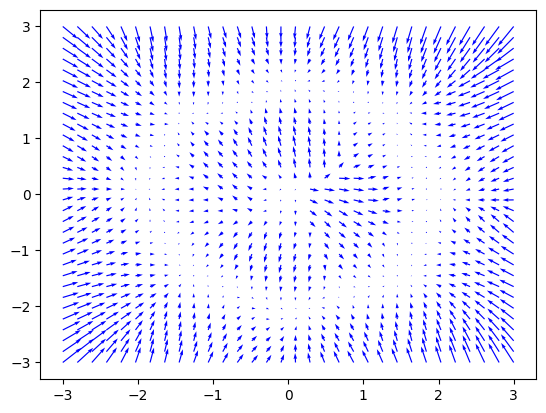

In [13]:
X, Y = jnp.meshgrid(jnp.linspace(-3, 3, 32), jnp.linspace(-3, 3, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

Traced<ShapedArray(float32[8])>with<DynamicJaxprTrace(level=1/0)>
[[ 5.0000000e+00  0.0000000e+00]
 [ 3.5355339e+00  3.5355341e+00]
 [-2.1855695e-07  5.0000000e+00]
 [-3.5355339e+00  3.5355341e+00]
 [-5.0000000e+00 -4.3711390e-07]
 [-3.5355334e+00 -3.5355344e+00]
 [ 5.9624405e-08 -5.0000000e+00]
 [ 3.5355351e+00 -3.5355327e+00]]


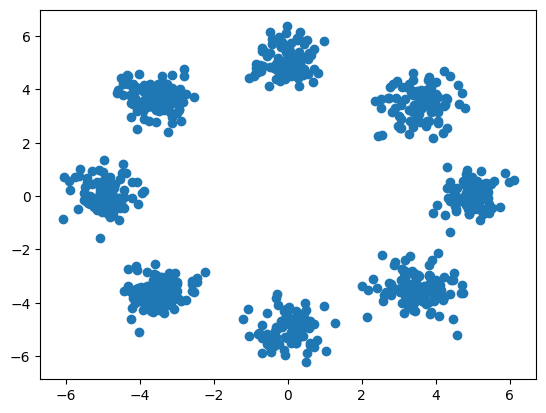

In [14]:
centers = circle_points(8, 5)
print(centers)
mixture_weight = jnp.ones(8) / 8
key, subkey = jrandom.split(key_gen())

compont = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(800, 1))

key, subkey = jrandom.split(key)
keys = jrandom.split(subkey, 800)
samples = jax.vmap(lambda center, key: jrandom.normal(key, (2,)) * 0.5 + center, in_axes=(0, 0))(centers[compont], keys)
plt.scatter(samples[:, :, 0], samples[:, :, 1])

## 2.3 Compare the learned score with the true score of a 2D Gaussian distribution

We sample the score of a given multivariate gaussian distribution, then using the model to learn the score.
Finally we compare the learned score with the true score. The tested distribution is a 2D Gaussian distribution, where the mean is [0, 0] and the covariance matrix is [[1, 0.5], [0.5, 2]]

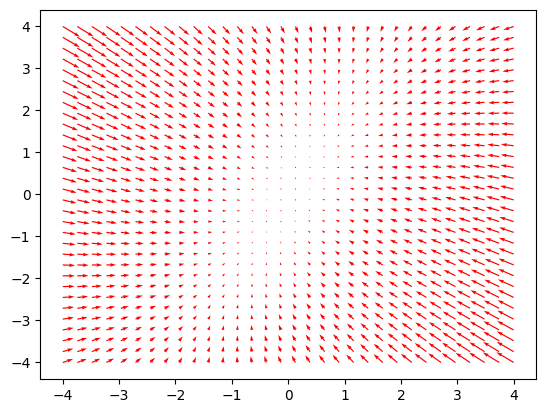

In [15]:
from jax.scipy.linalg import solve
from jax import grad, vmap

def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        1/((2 * jnp.pi) ** (d)
        * jnp.linalg.det(sigma))
        * jnp.exp(-x_centered.T @ jnp.linalg.inv(sigma) @ x_centered / 2)
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0])
sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
x = jnp.array([[0.5, 1.0], [1.0, 1.5], [1.5, 2.0]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')

In [16]:
@partial(jax.jit, static_argnums=(2,3))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma)
    if i % 1000 == 0:
        print(loss)

93.22999
101.72016
102.333275
100.8486
100.50798
93.01574
95.80317
100.392944
98.63865
102.28129


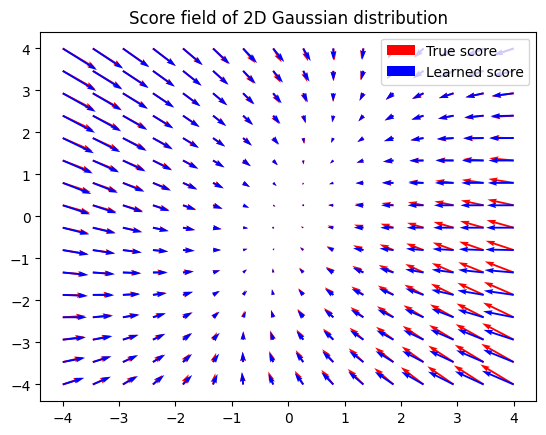

In [17]:
x,y = jnp.meshgrid(jnp.linspace(-4, 4, 16), jnp.linspace(-4, 4, 16))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
ax.quiver(Z[:, 0], Z[:, 1],result_pred[:, 0], result_pred[:, 1], color='b')
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 2D Gaussian distribution")
plt.show()

## 3. Do the DSM on the 3D Gaussian distribution

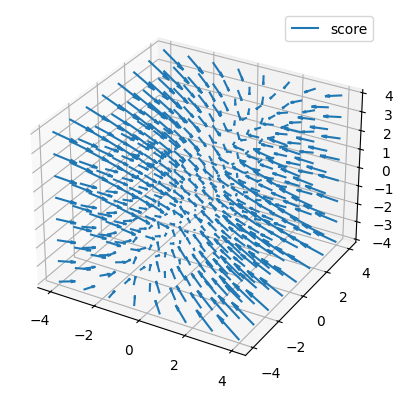

In [18]:
# 3D Gaussian distribution
def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        (2 * jnp.pi) ** (-d / 2)
        * jnp.linalg.det(sigma) ** (-1 / 2)
        * jnp.exp(-0.5 * x_centered.T @ solve(sigma, x_centered))
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0, 0.0])
sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
x = jnp.array([[0.5, 1.0, 1.5], [1.0, 1.5, 2.0], [1.5, 2.0, 2.5]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2)
ax.legend(["score"])
plt.show()

We can add the dim parameter to the MLP model to learn the 3D distribution.

In [19]:
class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x, dim):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=dim)(x)
        x = nn.leaky_relu(x)
        
        return x
    
# the init_train_state_onestep function should be modified to add the dim parameter
def init_train_state_onestep(key, model, x, dim) ->train_state.TrainState:
    params = model.init(key, x, dim=dim)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

In [20]:
@partial(jax.jit, static_argnums=(2,3,6))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma,dim):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x, dim)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 3)), dim=3)
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
for i in range(20000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma, 3)
    if i % 1000 == 0:
        print(loss)

158.08328
154.87584
148.19885
145.82417
147.72815
149.02373
156.59143
154.95665
147.1754
147.73825
140.76398
149.29501
150.53345
148.75714
145.95755
148.84319
136.14128
144.33244
140.67247
136.04729


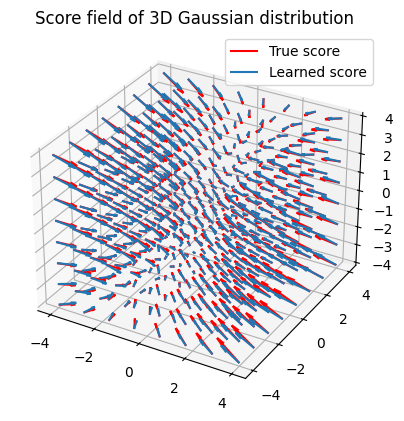

In [21]:
x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(lambda x: state.apply_fn(state.params, x, 3), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2, color='r')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result_pred[:, 0], result_pred[:, 1], result_pred[:, 2], length=0.2)
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 3D Gaussian distribution")
plt.show()

## 4. Score matching in a stochastic process

We will simulate the stochastic process in a Stochastic Differential Equation perspective, first we will simulate the Brownian Process and then we will simulate the Ornstein-Uhlenbeck process.


In [22]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax
import numpy as np
import random
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt

### 4.1 Brownian Process

In [23]:
# generate sigmas for the OU process, in a geometric sequence. Settings for the OU process
time_steps = 10 # the time steps for the OU process
sigma_start = 0.1 # the noise level at the first time step
sigma_end = 0.01 # the noise level at the last time step
sigmas = jnp.geomspace(sigma_start, sigma_end, time_steps) # generate a geometric sequence of noise levels

# define the model for fitting the score of the OU process
class ResidualBlock(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        residual = x
        x = nn.LayerNorm()(x)
        x = nn.Dense(features=self.features)(x)
        x = nn.swish(x)
        x = nn.Dense(features=x.shape[-1])(x)
        return x + residual

class SelfAttention(nn.Module):
    num_heads: int = 4

    @nn.compact
    def __call__(self, x):
        b, d = x.shape
        assert d % self.num_heads == 0, "Features must be divisible by num_heads"
        
        qkv = nn.Dense(features=d * 3, use_bias=False)(x)
        q, k, v = jnp.split(qkv, 3, axis=-1)
        q = q.reshape(b, self.num_heads, -1)
        k = k.reshape(b, self.num_heads, -1)
        v = v.reshape(b, self.num_heads, -1)

        attention = jnp.einsum('bhd,bHd->bhH', q, k) / jnp.sqrt(d // self.num_heads)
        attention = nn.softmax(attention, axis=-1)
        
        output = jnp.einsum('bhH,bHd->bhd', attention, v)
        output = output.reshape(b, d)
        return output


class AdvancedScoreNet(nn.Module):
    hidden_dims: tuple = (16,64, 128, 256,512,256, 128, 64,16)

    @nn.compact
    def __call__(self, x, t, dim):
        t = jnp.broadcast_to(t, x.shape)
        x = jnp.concatenate([x, t], axis=-1)
        for hidden_dim in self.hidden_dims[1:]:
            x = nn.Dense(features=hidden_dim)(x)
            x = nn.swish(x)
        x = nn.Dense(features=dim)(x)
        return x
            
        




First we generate the training data obeying the Brownian Process

In [24]:
# generate the training data obeying the Brownian Process
def gen_brownian_data(key, batch_size, time_steps, dim):
    
    x0 = jnp.zeros((batch_size, dim))
    keys = jrandom.split(key, batch_size * time_steps)
    keys = keys.reshape((batch_size, time_steps, -1))
    
    sigma_start = 0.5
    sigma_end = 0.1
    sigmas = jnp.geomspace(sigma_start, sigma_end, time_steps)
    
    def add_noise_one_step(x, key, sigma):
        return x + jrandom.normal(key, x.shape) * sigma
    x_list = []
    x_list.append(x0)
    for i in range(time_steps):
        key = keys[:, i]
        x0 = jax.vmap(add_noise_one_step, in_axes=(0, 0, None))(x0, key, sigmas[i])
        x_list.append(x0)
    key = keys[-1, -1, :]
    
    return jnp.stack(x_list, axis=1), key # shape: (batch_size, time_steps, dim)
    
time_steps = 200
training_data, key = gen_brownian_data(key_gen(), 10, time_steps, 2)
globe_key = key

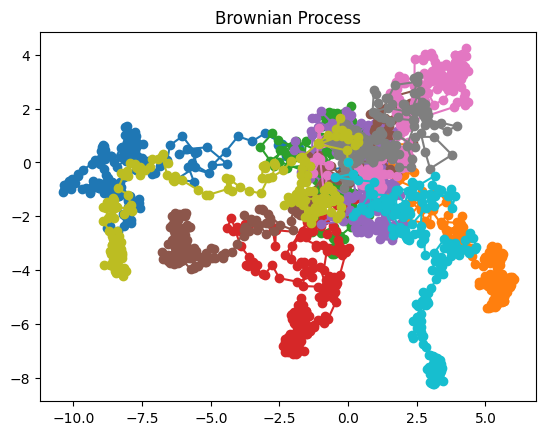

In [25]:
def plot_trajectory(trajectory, dim):
    fig, ax = plt.subplots()
    for i in range(trajectory.shape[0]):
        ax.plot(trajectory[i, :, 0], trajectory[i, :, 1], marker='o')
    ax.set_title("Brownian Process")
    plt.show()
    
plot_trajectory(training_data, 2)
    


The Brownian Motion (Wiener Process) can be represented by $dX(t) = \sigma dW(t) $, and the Euler-Maruyama can be used to solve the Brownian Motion. The One step of Euler-Maruyama can be represented by $X(t + \Delta t) = X(t) + \sigma \Delta W(t)$, where $\Delta W(t) = W(t + \Delta t) - W(t)$, and $\Delta W(t) \sim N(0, \Delta t)$

In [26]:
# Define the Euler-Maruyama method to solve the Brownian Motion
class EulerMaruyama:
    def __init__(self, x0, dim, batch_size,sigma, time_steps, key):
        self.dim = dim
        self.sigma = sigma
        self.time_steps = time_steps
        self.dt = 1.0 / time_steps
        self.key = key
        self.x0 = x0
        self.batch_size = batch_size
    def renew_key(self, batch_size):
        self.key, subkey = jrandom.split(self.key)
        return jrandom.split(subkey, batch_size)
    def sample_dW(self, key):
        return jrandom.normal(key, (self.dim,)) * jnp.sqrt(self.dt)

    def one_step(self, x, key):
        dW = self.sample_dW(key)
        x = x + self.sigma * dW
        return x


    def solve(self):
        x = self.x0
        x_list = []
        x_list.append(x)
        for i in range(self.time_steps):
            key = self.renew_key(self.batch_size)
            xs = jax.vmap(self.one_step, in_axes=(0, 0))(x, key)
            x = xs
            x_list.append(x)
        return jnp.stack(x_list, axis=1)   
    def return_key(self):
        return self.key

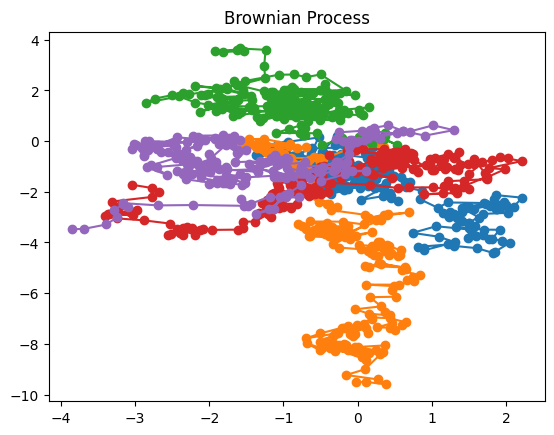

In [27]:

# Generate the training data using the Euler-Maruyama method
sigma = 3
time_steps = 200
batch_size = 5
dim = 2
x0 = jnp.zeros((batch_size, dim))
key = key_gen()
em = EulerMaruyama(x0, dim, batch_size, sigma, time_steps, key)
key = em.return_key()
globe_key = key
training_data = em.solve()
plot_trajectory(training_data, dim)

In [28]:
# init the model and the training state
def init_train_state_Brownian(key, model, x, t, dim) ->train_state.TrainState:
    params = model.init(key, x, t, dim=dim)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

model = AdvancedScoreNet()
subkey = key_gen()
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)
@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_Brownian(key, state, sigma, batch_size, time_steps, dim):
    key, subkey = jrandom.split(key)
    em = EulerMaruyama(jnp.zeros((batch_size, dim)), dim, batch_size, sigma, time_steps, key)
    key = em.return_key()
    x = em.solve()
    t = jnp.array([0.0])
    ts = jnp.linspace(0, 1, time_steps + 1)
    ts = ts[1:]
    dt = 1.0 / time_steps
    x_original = x[:, :-1, :]
    x0s = x[:, 0, :]
    x0s = jnp.expand_dims(x0s, axis=1)
    x0s = jnp.repeat(x0s, time_steps, axis=1)
    x_noised = x[:, 1:, :]
    
    

    def total_loss(params):
        
        def one_step_dsm(x_original, x_noised, t):
            def mse(x_original, x_noised, t):
                pred = state.apply_fn(params, x_noised, t, dim)
                true = (x_original - x_noised) / (sigma**2 * t)
                return (jnp.linalg.norm(pred - true) ** 2) / 2
            return jnp.mean(jax.vmap(mse, in_axes=(0, 0, None))(x_original, x_noised, t), axis=0)      
            # def ssm(x_original, x_noised, t):
            #     pred = state.apply_fn(params, x_noised, t, dim)
            #     pred_grad_fn = jax.grad(state.apply_fn)
            #     pred_grad = pred_grad_fn(params, x_noised, t, dim)
            #     v = jrandom.normal(subkey, x_noised.shape)
            #     true = v.T @ pred_grad @ v
            #     return 
        return jnp.mean(jax.vmap(one_step_dsm, in_axes=(1, 1, 0))(x0s, x_noised, ts))
    loss, grad = jax.value_and_grad(total_loss)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss, key

Given the training data, we can use the model to learn the score of the Brownian Motion

In [29]:
import tqdm
import sys
sigma = 3
time_steps = 100
batch_size = 50
dim = 2

losses = []
for i in tqdm.trange(10000, file=sys.stdout):
    
    subkey = key_gen()
    state, loss, key = update_step_Brownian(subkey, state, sigma, batch_size, time_steps, dim)
    globe_key = key
    losses.append(loss)
    if i % 1000 == 0:
        tqdm.tqdm.write(f"Loss: {loss}")
        


Loss: 0.5313755869865417                 
Loss: 0.00019219804380554706                         
Loss: 0.00018229718261864036                         
Loss: 0.00019576388876885176                         
Loss: 4.8988607886713e-05                            
Loss: 8.470680040773004e-05                          
Loss: 0.000431673921411857                           
Loss: 0.0001493112213211134                          
Loss: 0.0003312435292173177                          
Loss: 4.016217644675635e-05                          
100%|██████████| 10000/10000 [01:09<00:00, 144.15it/s]


In [30]:
from jax.scipy.stats import multivariate_normal
@partial(jax.jit, static_argnums=(1,2,3))
def wiener_real_score(x, t, dim, sigma = 1):
    
    log_pdf = lambda x: jnp.log(multivariate_normal.pdf(x, mean=jnp.zeros(dim), cov=sigma**2 * t * jnp.eye(dim)))
    # log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, jnp.zeros(dim), sigma**2 * t * jnp.eye(dim)))
    return grad(log_pdf)(x)
# evaluation mse
def mse_eval_loss(pred, true):
    return jnp.mean(jnp.linalg.norm(pred - true, axis=-1) ** 2)

Now we can plot the learned score of the Brownian Motion of given time steps

In [31]:
def plot_score_field(state, dim, time, color='b'):
    x = jnp.linspace(-3, 3, 32)
    y = jnp.linspace(-3, 3, 32)
    x, y = jnp.meshgrid(x, y)
    Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
    Z_dummy = jnp.zeros((Z.shape[0], dim-2))
    Z = jnp.concatenate([Z, Z_dummy], axis=-1)
    result = jax.vmap(lambda x: state.apply_fn(state.params, x, time, dim), in_axes=(0))(Z)
    print(Z.shape)
    real_score = jax.vmap(lambda x: wiener_real_score(x, time, dim, 3), in_axes=(0))(Z)
    loss = jax.vmap(mse_eval_loss)(result, real_score)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.quiver(Z[:, 0], Z[:, 1],real_score[:, 0], real_score[:, 1], color='r', zorder=10 )
    ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color=color, zorder=5)
    ax.set_title("Score field of Brownian Motion at time " + str(time)+ ", loss: " + str(jnp.mean(loss)))
    ax.legend(["True score", "Learned score"])
    plt.show()

(1024, 2)


/home/zjc/.conda/envs/hyperiax2/lib/python3.11/site-packages/matplotlib/quiver.py:630: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/zjc/.conda/envs/hyperiax2/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


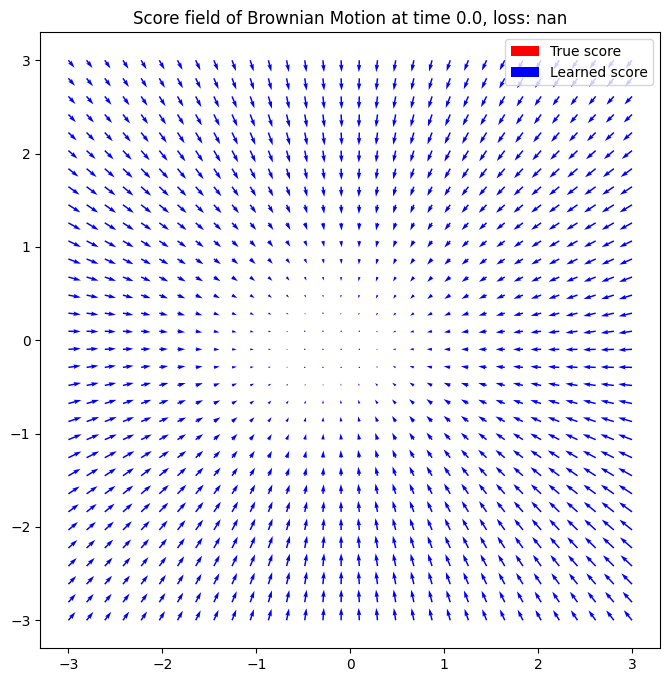

(1024, 2)


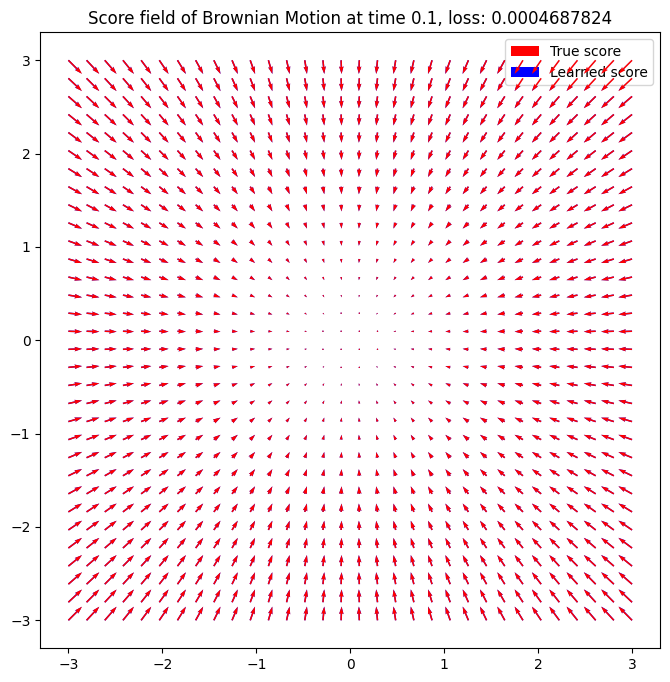

(1024, 2)


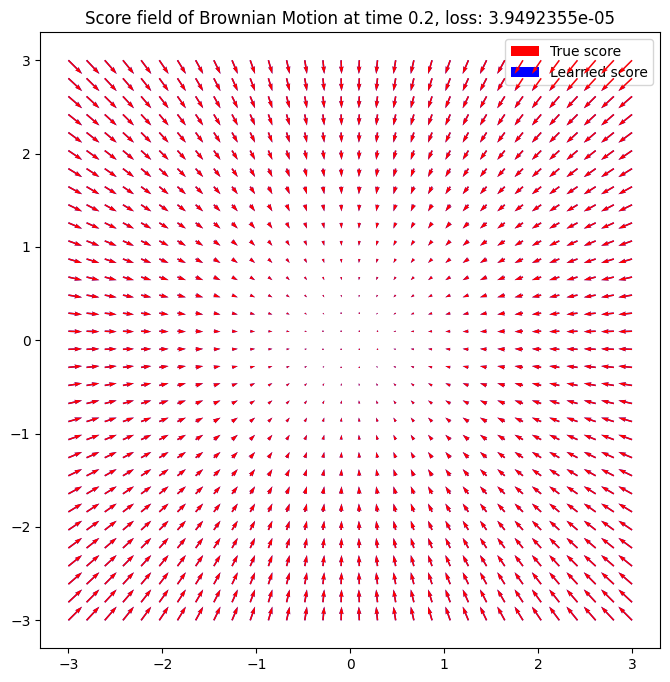

(1024, 2)


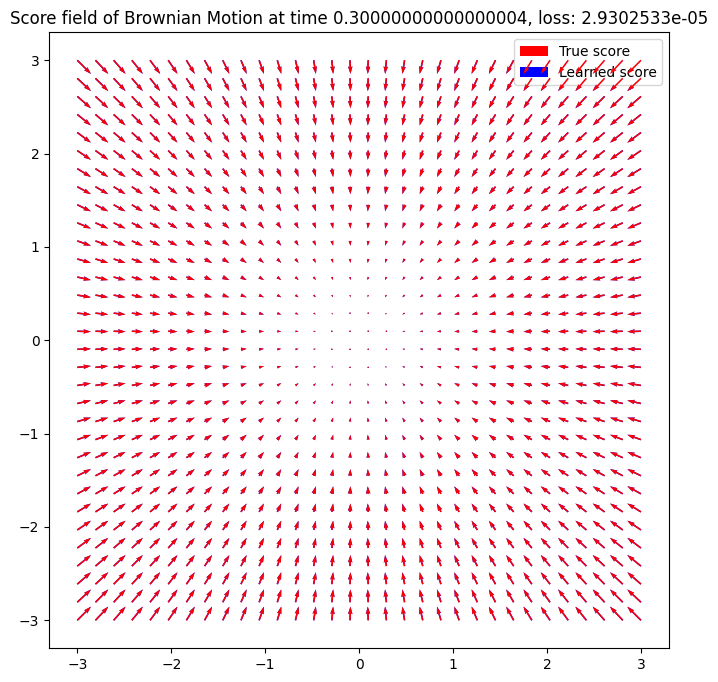

(1024, 2)


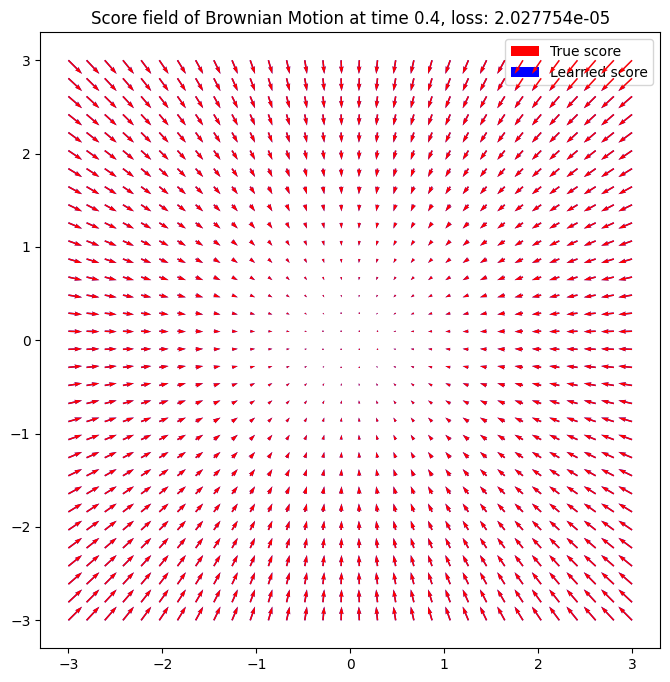

(1024, 2)


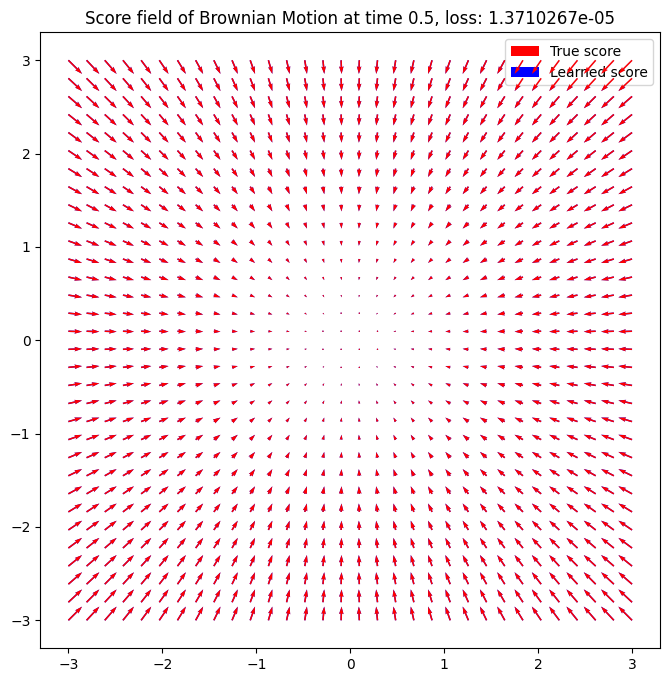

(1024, 2)


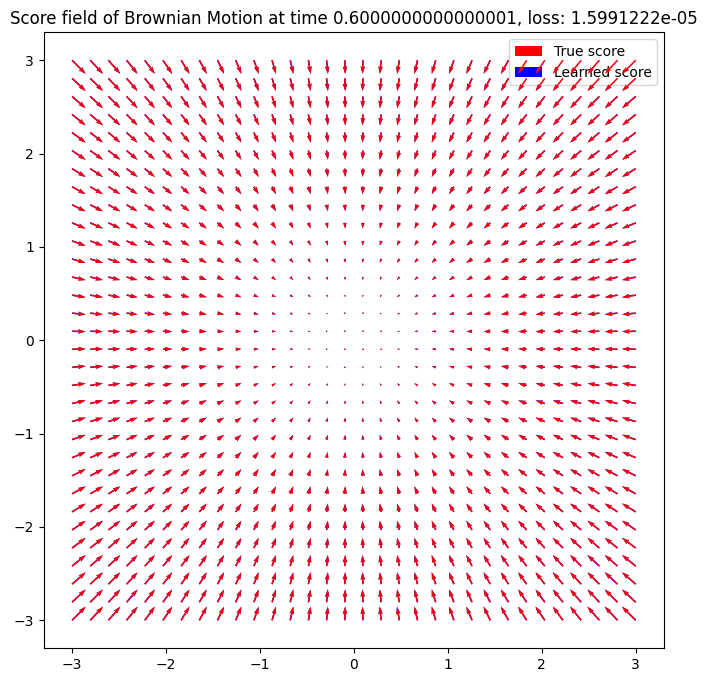

(1024, 2)


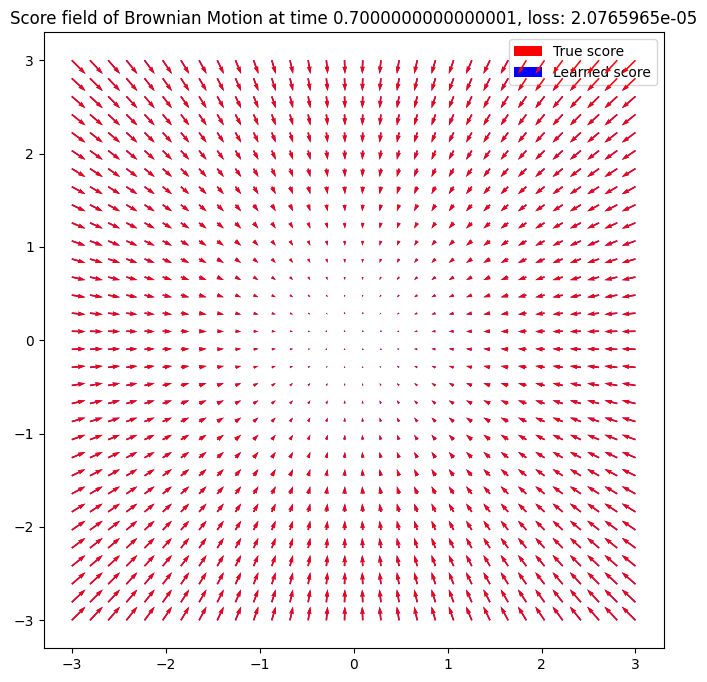

(1024, 2)


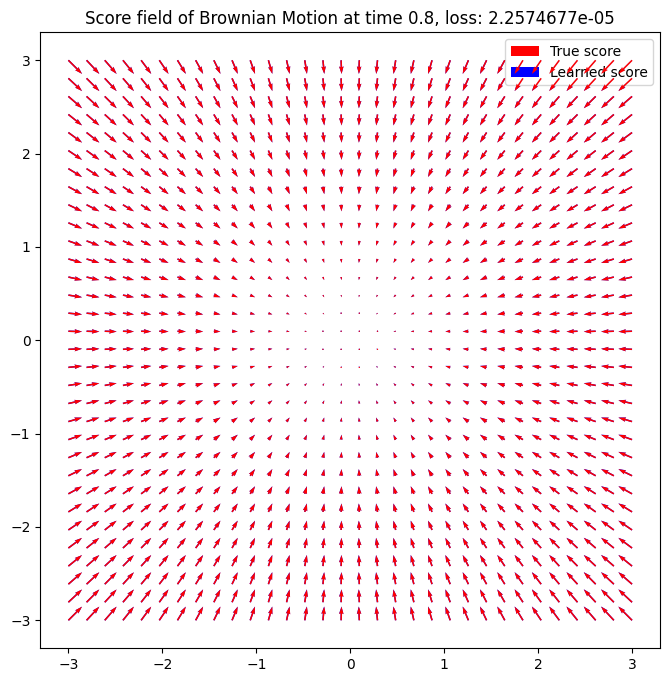

(1024, 2)


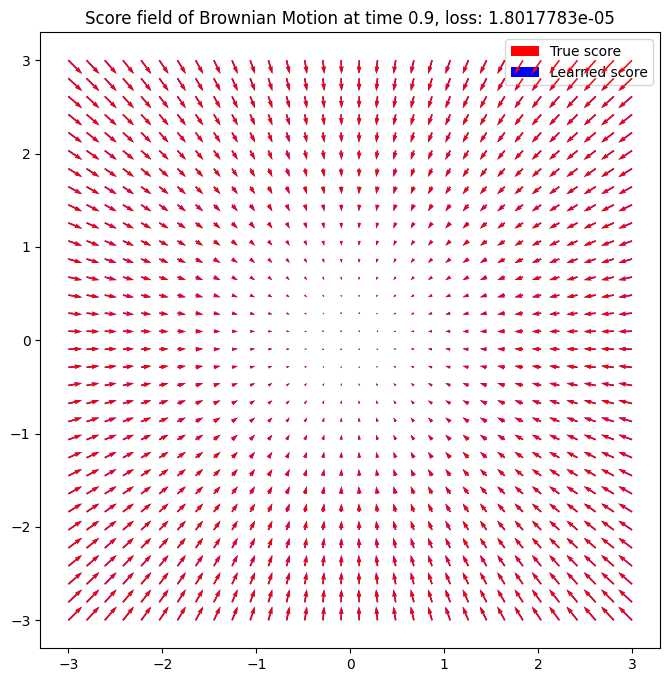

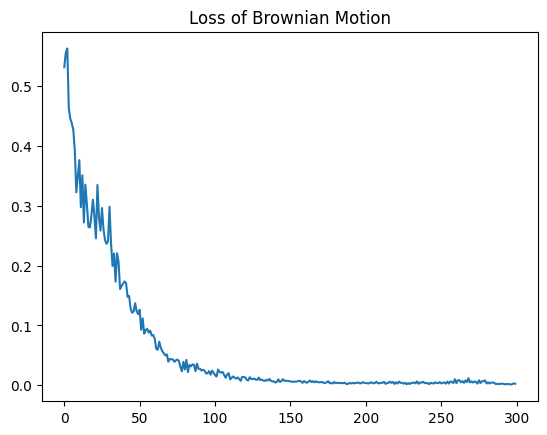

In [32]:
cmap = plt.get_cmap('viridis')
for i in range(10):
    plot_score_field(state, dim, i * 0.1, color='b')

# plot_score_field(state, dim, 1)
fig, ax = plt.subplots()
ax.plot(losses[:300])
ax.set_title("Loss of Brownian Motion")
plt.show()

To train the model on the R100, and plot the marginal distribution in R2

In [33]:
dim = 100
losses = []
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)
for i in tqdm.trange(10000, file=sys.stdout):
    
    subkey = key_gen()
    state, loss, key = update_step_Brownian(subkey, state, sigma, batch_size, time_steps, dim)
    globe_key = key
    losses.append(loss)
    if i % 1000 == 0:
        tqdm.tqdm.write(f"Loss: {loss}")

Loss: 28.953039169311523                 
Loss: 24.45191764831543                              
Loss: 24.12480926513672                              
Loss: 24.27189826965332                              
Loss: 24.121450424194336                             
Loss: 24.480541229248047                             
Loss: 23.884233474731445                             
Loss: 24.43926429748535                              
Loss: 24.103368759155273                             
Loss: 24.104347229003906                             
100%|██████████| 10000/10000 [01:29<00:00, 111.79it/s]


(1024, 100)


/home/zjc/.conda/envs/hyperiax2/lib/python3.11/site-packages/matplotlib/quiver.py:630: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/zjc/.conda/envs/hyperiax2/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


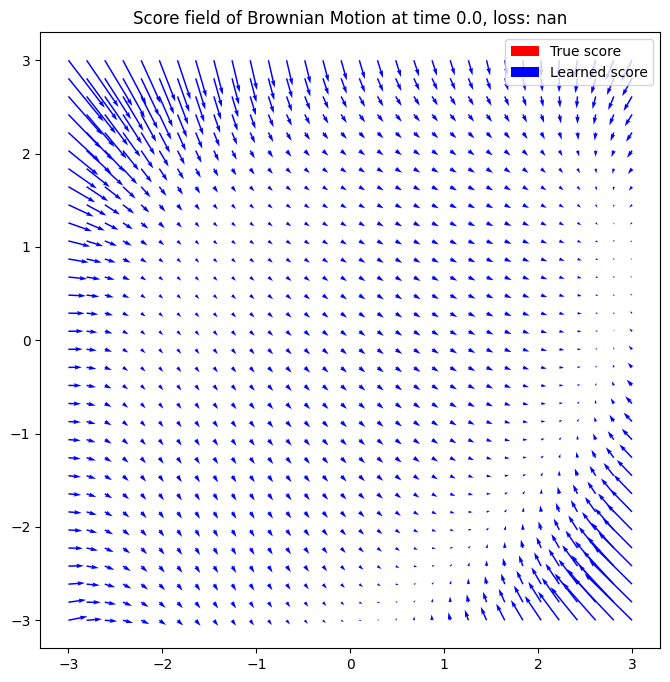

(1024, 100)


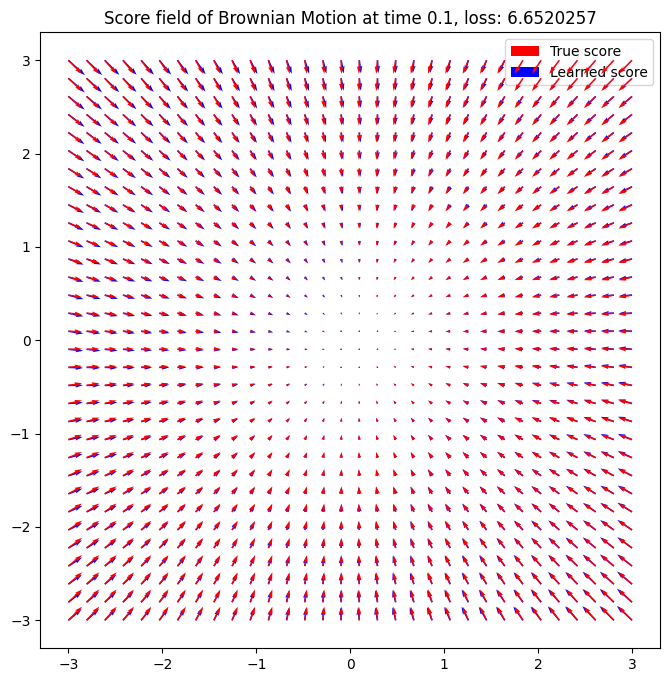

(1024, 100)


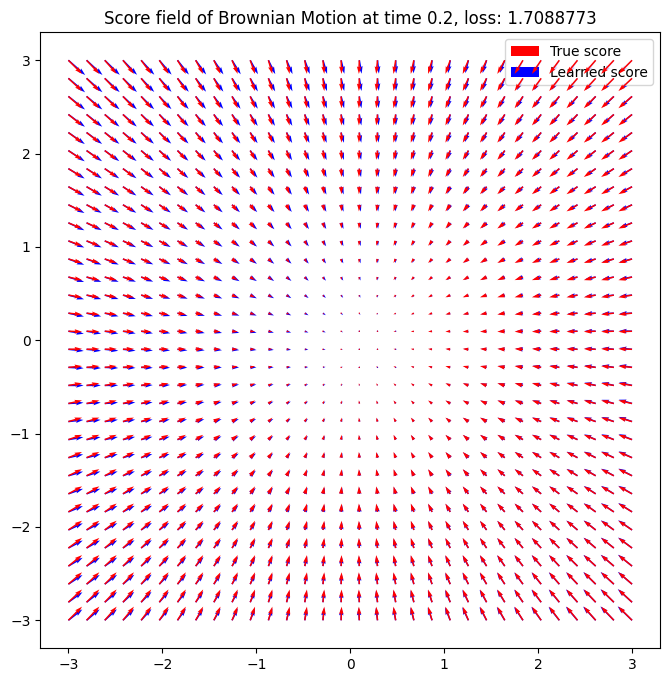

(1024, 100)


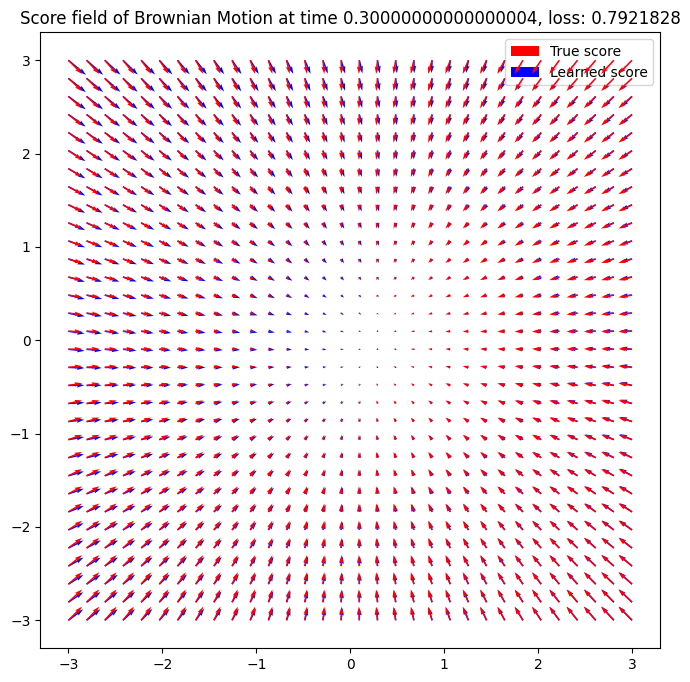

(1024, 100)


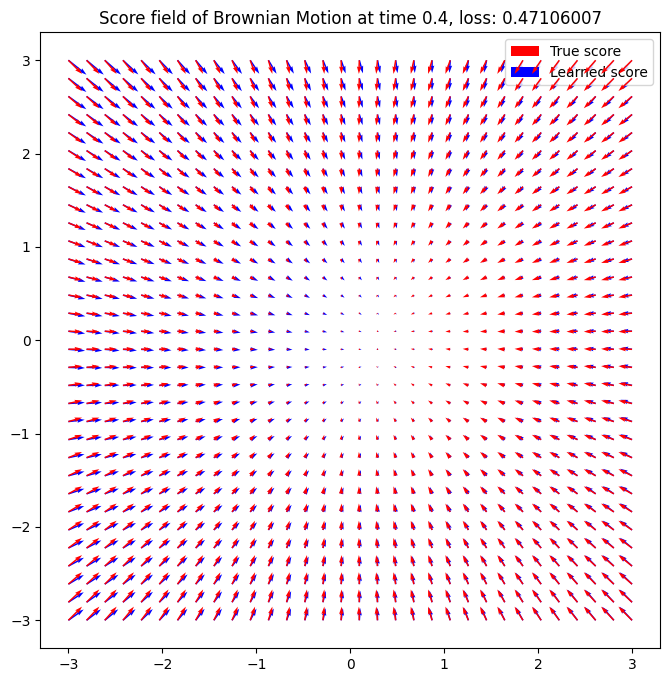

(1024, 100)


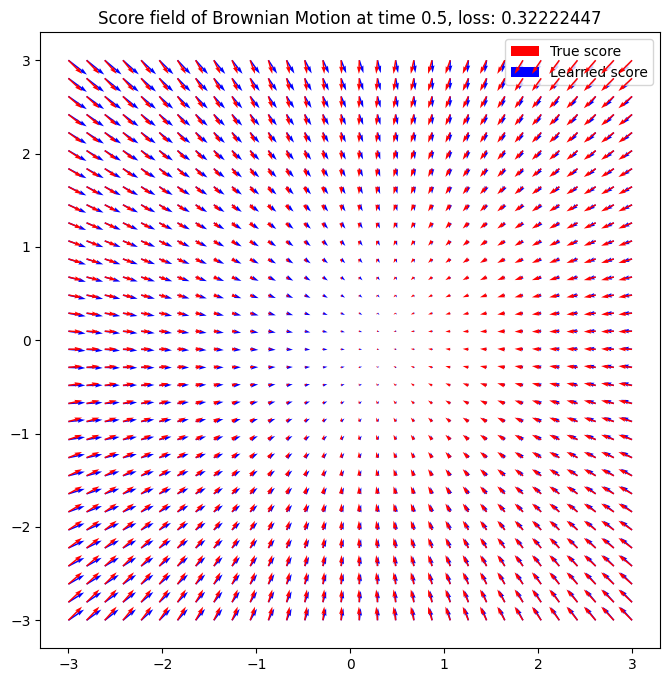

(1024, 100)


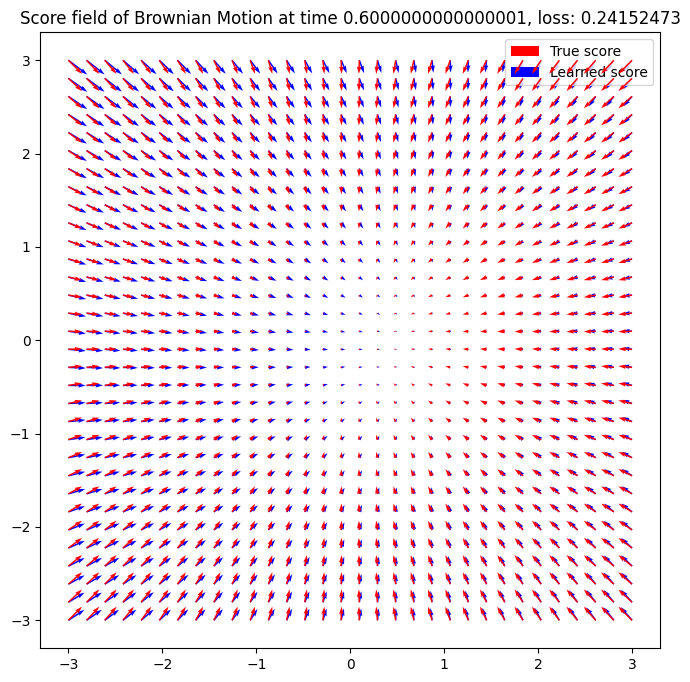

(1024, 100)


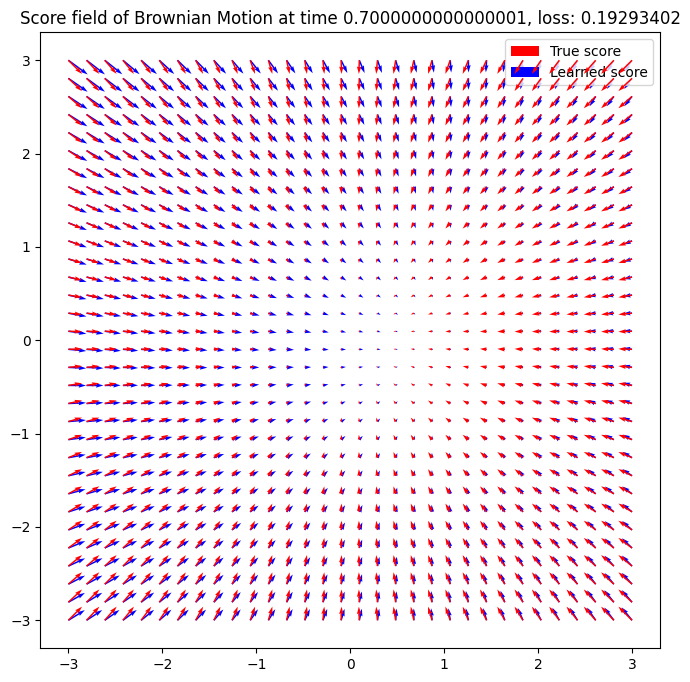

(1024, 100)


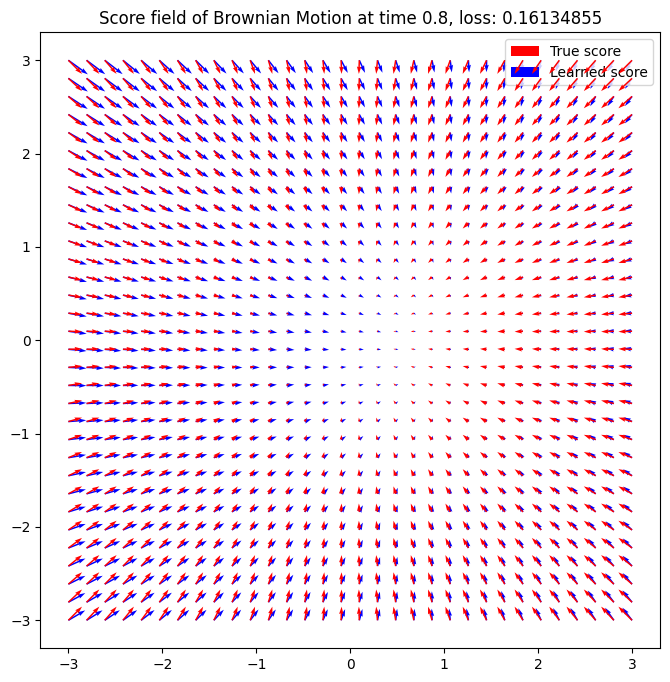

(1024, 100)


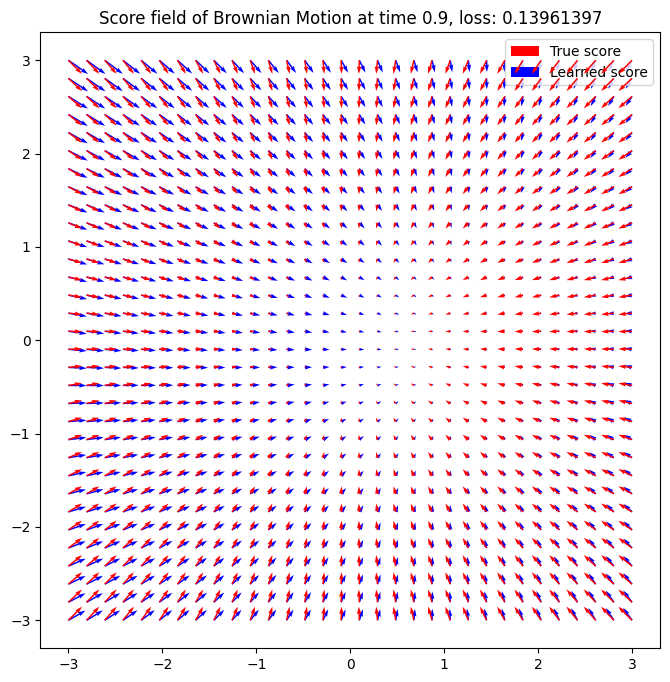

In [34]:
for i in range(10):
    plot_score_field(state, dim, i * 0.1, color='b')

### 4.2 Ornstein-Uhlenbeck process simulation

The Ornstein 

In [35]:
# R^100, plot marginal distribution(R2) (achieved)
# OU process 
# code example. kunita flow (to 3D)
# neural operator graph (future work)

In [1]:
from src.SDESolver import EulerMaruyama
import jax.numpy as jnp
import jax.random as jrandom
import jax
import tqdm
import random
from src.plot import plot_trajectory_2d
from flax import linen as nn
import optax
import numpy as np
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt
import sys
from src.SDE import *
from jax.scipy.linalg import sqrtm


In [2]:
seed = 0
rand_seed = random.randint(0, 1000000)
globe_key = jrandom.PRNGKey(rand_seed)
subkey = jrandom.split(globe_key)[0]
def key_gen():
    global globe_key
    new_key, subkey = jrandom.split(globe_key)
    globe_key = new_key
    return subkey

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151516 0.16161616 0.17171717
 0.18181819 0.1919192  0.2020202  0.21212122 0.22222222 0.23232323
 0.24242425 0.25252524 0.26262626 0.27272728 0.28282827 0.2929293
 0.3030303  0.3131313  0.32323232 0.33333334 0.34343433 0.35353535
 0.36363637 0.37373737 0.3838384  0.3939394  0.4040404  0.41414142
 0.42424244 0.43434343 0.44444445 0.45454547 0.46464646 0.47474748
 0.4848485  0.4949495  0.5050505  0.5151515  0.5252525  0.53535354
 0.54545456 0.5555556  0.56565654 0.57575756 0.5858586  0.5959596
 0.6060606  0.61616164 0.6262626  0.6363636  0.64646465 0.65656567
 0.6666667  0.67676765 0.68686867 0.6969697  0.7070707  0.7171717
 0.72727275 0.7373737  0.74747473 0.75757575 0.7676768  0.7777778
 0.7878788  0.7979798  0.8080808  0.8181818  0.82828283 0.83838385
 0.8484849  0.85858583 0.86868685 0.8787879  0.8888889  0.8989899


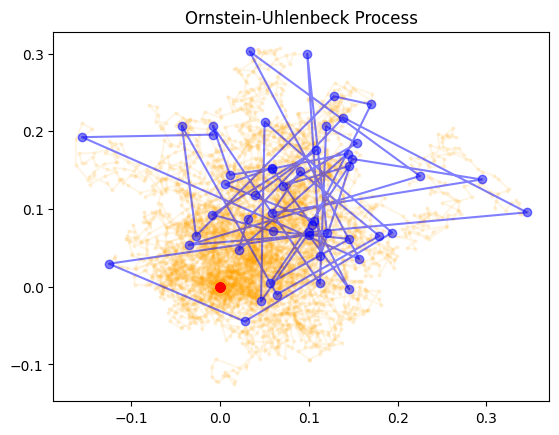

In [3]:
# Euler-Maruyama for OU process


kappa =1
theta = 0.1
batch_size = 50
dim = 2
time_steps = 100
sigma = 0.1
mu = jnp.ones(dim) * 1.0
ou_sde = Ornstein_Uhlenbeck_SDE(theta, mu, sigma)
total_time = 1


x0 = jnp.zeros((batch_size, dim))
rng_key = key_gen()
em_ou = EulerMaruyama.from_sde(ou_sde, x0, total_time/time_steps, total_time, batch_size, rng_key)
training_data, diffusion_history = em_ou.solve()
print(training_data.shape)
plot_trajectory_2d(training_data, "Ornstein-Uhlenbeck Process")


class AdvancedScoreNet(nn.Module):
    hidden_dims: tuple = (16,64, 128,256, 512, 256, 128, 64,16)

    @nn.compact
    def __call__(self, x, t, dim):
        t = jnp.broadcast_to(t, x.shape)
        x = jnp.concatenate([x, t], axis=-1)
        for hidden_dim in self.hidden_dims:
            x = nn.Dense(features=hidden_dim)(x)
            x = nn.swish(x)
        x = nn.Dense(features=dim)(x)
        return x
    
def init_train_state_Brownian(key, model, x, t, dim) ->train_state.TrainState:
    params = model.init(key, x, t, dim=dim)
    optimizer = optax.adam(learning_rate=1e-4)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )
            

In [4]:
model = AdvancedScoreNet()
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)
@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_OU(key, state, sigma, batch_size, time_steps, dim):
    key, subkey = jrandom.split(key)
    em = EulerMaruyama.from_sde(ou_sde, jnp.zeros((batch_size, dim)), total_time/time_steps, total_time, batch_size, subkey)
    x, diffusion_history = em.solve()
    t = jnp.array([0.0])
    ts = jnp.linspace(0, 1, time_steps + 1)
    ts = ts[1:]
    dt = 1.0 / time_steps
    x0s = jnp.zeros((batch_size, dim))
    x0s = jnp.expand_dims(x0s, axis=0)
    x0s = jnp.repeat(x0s, time_steps, axis=0)
    x_noised = x[1:, :, :]
    x_originals = x[:-1, :, :]
    
    

    def total_loss(params):
        
        def one_step_dsm(x_original, x_noised, t):
            def mse(x_original, x_noised, t):
                pred = state.apply_fn(params, x_noised, t, dim)
                true = (x_original - x_noised) / (sigma**2 * t)
                return (jnp.linalg.norm(pred - true) ** 2) / 2
            return jnp.mean(jax.vmap(mse, in_axes=(0, 0, None))(x_original, x_noised, t), axis=0)
        return jnp.mean(jax.vmap(one_step_dsm, in_axes=(0, 0, 0))(x0s, x_noised, ts))
    loss, grad = jax.value_and_grad(total_loss)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss, key

losses = []
#for i in tqdm.trange(5000, file=sys.stdout):
    
#    subkey = key_gen()
#    state, loss, key = update_step_OU(subkey, state, sigma, batch_size, time_steps, dim)
#    globe_key = key
#    losses.append(loss)
#    if i % 1000 == 0:
#        tqdm.tqdm.write(f"Loss: {loss}")

In [5]:
from src.stats import OU_transition_density_log
from jax import grad

def mse_eval_loss(pred, true):
    return jnp.mean(jnp.linalg.norm(pred - true, axis=0) ** 2)

def OU_score(x,t, x0, t0, theta, sigma):
    sigma = jnp.eye(x0.shape[0]) * sigma
    D = sigma @ sigma.T / theta
    mean = x0 * jnp.exp(-theta*(t-t0))
    variance = D * (1-jnp.exp(-2*theta*(t-t0)))
    # variance = jnp.eye(mean.shape[-1]) * variance
    log_pdf = lambda x : jnp.log(jax.scipy.stats.multivariate_normal.pdf(x, mean, variance))
    return grad(log_pdf)(x)

def plot_score_field_OU(state, dim, time, color='b'):
    x = jnp.linspace(-3, 3, 32)
    y = jnp.linspace(-3, 3, 32)
    x, y = jnp.meshgrid(x, y)
    Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
    Z_dummy = jnp.zeros((Z.shape[0], dim-2))
    Z = jnp.concatenate([Z, Z_dummy], axis=-1)
    result = jax.vmap(lambda x: state.apply_fn(state.params, x, time, dim), in_axes=(0))(Z)
    x0 = jnp.zeros(dim)
    real_score = jax.vmap(lambda x: OU_score(x, time, x0, 0, theta, sigma), in_axes=(0))(Z) #x0 should not be (batch_size, dim) or grad will error
    loss = jax.vmap(mse_eval_loss)(result, real_score)
    fig, ax = plt.subplots(figsize=(10, 10))
    q1 = ax.quiver(Z[:, 0], Z[:, 1],real_score[:, 0], real_score[:, 1], color='tomato', zorder=10, pivot='mid',units='xy')
    # qk1 = ax.quiverkey(q1, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   # coordinates='figure')
    q2 = ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color=color, zorder=5, pivot='mid',units='xy')
    # qk2 = ax.quiverkey(q2, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='S',
    #                coordinates='figure')
    ax.scatter(Z[:, 0], Z[:, 1], color='black', zorder=15, s=1)
    ax.set_title("Score field of Brownian Motion at time " + str(time)+ ", loss: " + str(jnp.mean(loss)))
    ax.legend(["True score", "Learned score"])
    plt.show()
    
# for i in range(10):
#    plot_score_field_OU(state, dim, (i+1) * 0.1, color='deepskyblue')
# # plot_score_field_OU(state, dim, 2, color='b')


When sigma is small, the data cannot be spread out in the whole space, so the learned score is not accurate.
When sigma is large, the data is more spread out, so the learned score is more accurate.

## 4.3 Brownian Bridge (learn score on the original process and use the score to generate the reversed process)


[0.         0.00787402 0.01574803 0.02362205 0.03149606 0.03937008
 0.04724409 0.05511811 0.06299213 0.07086614 0.07874016 0.08661418
 0.09448819 0.1023622  0.11023622 0.11811024 0.12598425 0.13385826
 0.14173228 0.1496063  0.15748031 0.16535433 0.17322835 0.18110237
 0.18897638 0.19685039 0.2047244  0.21259843 0.22047244 0.22834645
 0.23622048 0.24409449 0.2519685  0.25984251 0.26771653 0.27559054
 0.28346455 0.2913386  0.2992126  0.30708662 0.31496063 0.32283464
 0.33070865 0.33858266 0.3464567  0.35433072 0.36220473 0.37007874
 0.37795275 0.38582677 0.39370078 0.4015748  0.4094488  0.41732284
 0.42519686 0.43307087 0.44094488 0.4488189  0.4566929  0.46456692
 0.47244096 0.48031497 0.48818898 0.496063   0.503937   0.511811
 0.51968503 0.52755904 0.53543305 0.54330707 0.5511811  0.5590551
 0.5669291  0.5748032  0.5826772  0.5905512  0.5984252  0.6062992
 0.61417323 0.62204725 0.62992126 0.63779527 0.6456693  0.6535433
 0.6614173  0.6692913  0.6771653  0.68503934 0.6929134  0.7007874
 

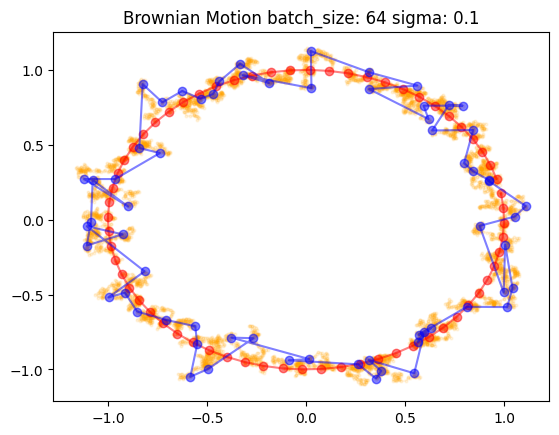

In [6]:
batch_size = 64
# let x0 be a sample from a circle, sample size is batch_size, sample on the circle uniformly
radius = 1
time_steps = 128
total_time = 1.0

def generate_circle_data(batch_size, radius):
    step_size = 2*jnp.pi / (batch_size-1)
    rand_phase = jrandom.uniform(key_gen())
    circle_x0 = jnp.stack([radius * jnp.cos(jnp.linspace(rand_phase, 2*jnp.pi-step_size + rand_phase, batch_size)), radius * jnp.sin(jnp.linspace(rand_phase, 2*jnp.pi-step_size + rand_phase, batch_size))], axis=-1)
    return circle_x0

circle_x0 = generate_circle_data(batch_size, radius)
Brownian_SDE = Brownian_Motion_SDE(dim, sigma)
sde_solver = EulerMaruyama.from_sde(Brownian_SDE, circle_x0, total_time/time_steps, total_time, batch_size, key_gen()) 
training_data_brownian, diffusion_history_brownian = sde_solver.solve()
plot_trajectory_2d(training_data_brownian, "Brownian Motion"+" batch_size: "+str(batch_size)+" sigma: "+str(sigma))

## 5. Kunita Flow

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705883 0.0509804  0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411766 0.09803922 0.10196079 0.10588236 0.10980393 0.1137255
 0.11764707 0.12156864 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.18823531 0.19215688 0.19607845 0.20000002 0.20392159 0.20784315
 0.21176472 0.21568629 0.21960786 0.22352943 0.227451   0.23137257
 0.23529413 0.2392157  0.24313727 0.24705884 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.34901962

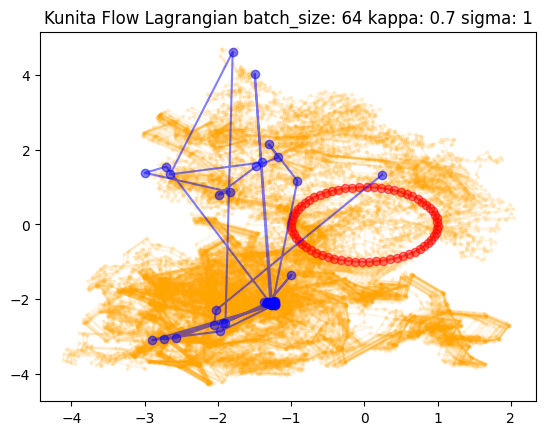

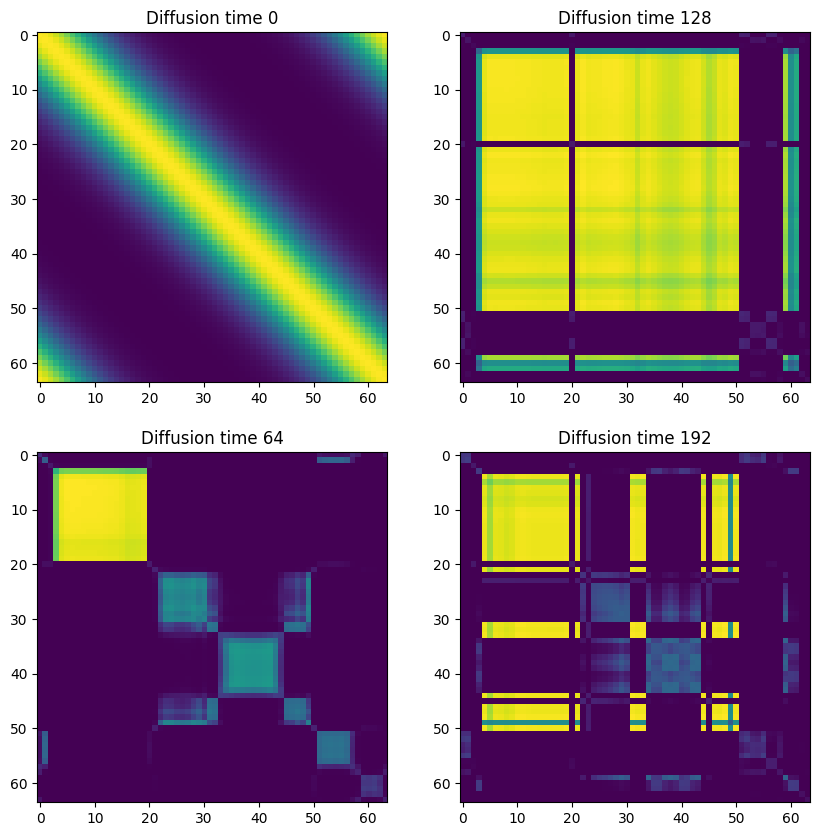

In [7]:
sigma = 1
kappa = 0.7
Kunita_flow = Kunita_Lagrange_SDE(sigma, kappa)
batch_size = 64
time_steps = 256
total_time = 1.0
circle_x0 = generate_circle_data(batch_size, radius)

sde_solver = EulerMaruyama.from_sde(Kunita_flow, circle_x0, total_time/time_steps, total_time, batch_size, key_gen()) 
training_data_lagrangian, diffusion_history_lagrangian = sde_solver.solve()
plot_trajectory_2d(training_data_lagrangian, "Kunita Flow Lagrangian"+" batch_size: "+str(batch_size)+" kappa: "+str(kappa)+" sigma: "+str(sigma))
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(jnp.linalg.matmul(diffusion_history_lagrangian[time_steps*(i+j*2)//4], diffusion_history_lagrangian[time_steps*(i+j*2)//4].T))
        ax[i,j].set_title("Diffusion time "+str(time_steps*(i+j*2)//4))
        # for k in range(batch_size):
        #     for l in range(batch_size):
        #         # use the scientific notation for the text
        #         ax[i,j].text(l, k, str("{:.2e}".format(diffusion_history[time_steps*(i+j*2)//4][k,l])), color='w', ha='center', va='center', fontsize=6)


plt.show()



[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705883 0.0509804  0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411766 0.09803922 0.10196079 0.10588236 0.10980393 0.1137255
 0.11764707 0.12156864 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.18823531 0.19215688 0.19607845 0.20000002 0.20392159 0.20784315
 0.21176472 0.21568629 0.21960786 0.22352943 0.227451   0.23137257
 0.23529413 0.2392157  0.24313727 0.24705884 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.34901962

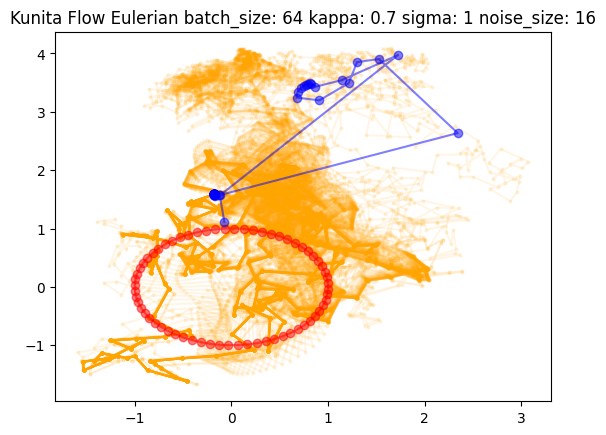

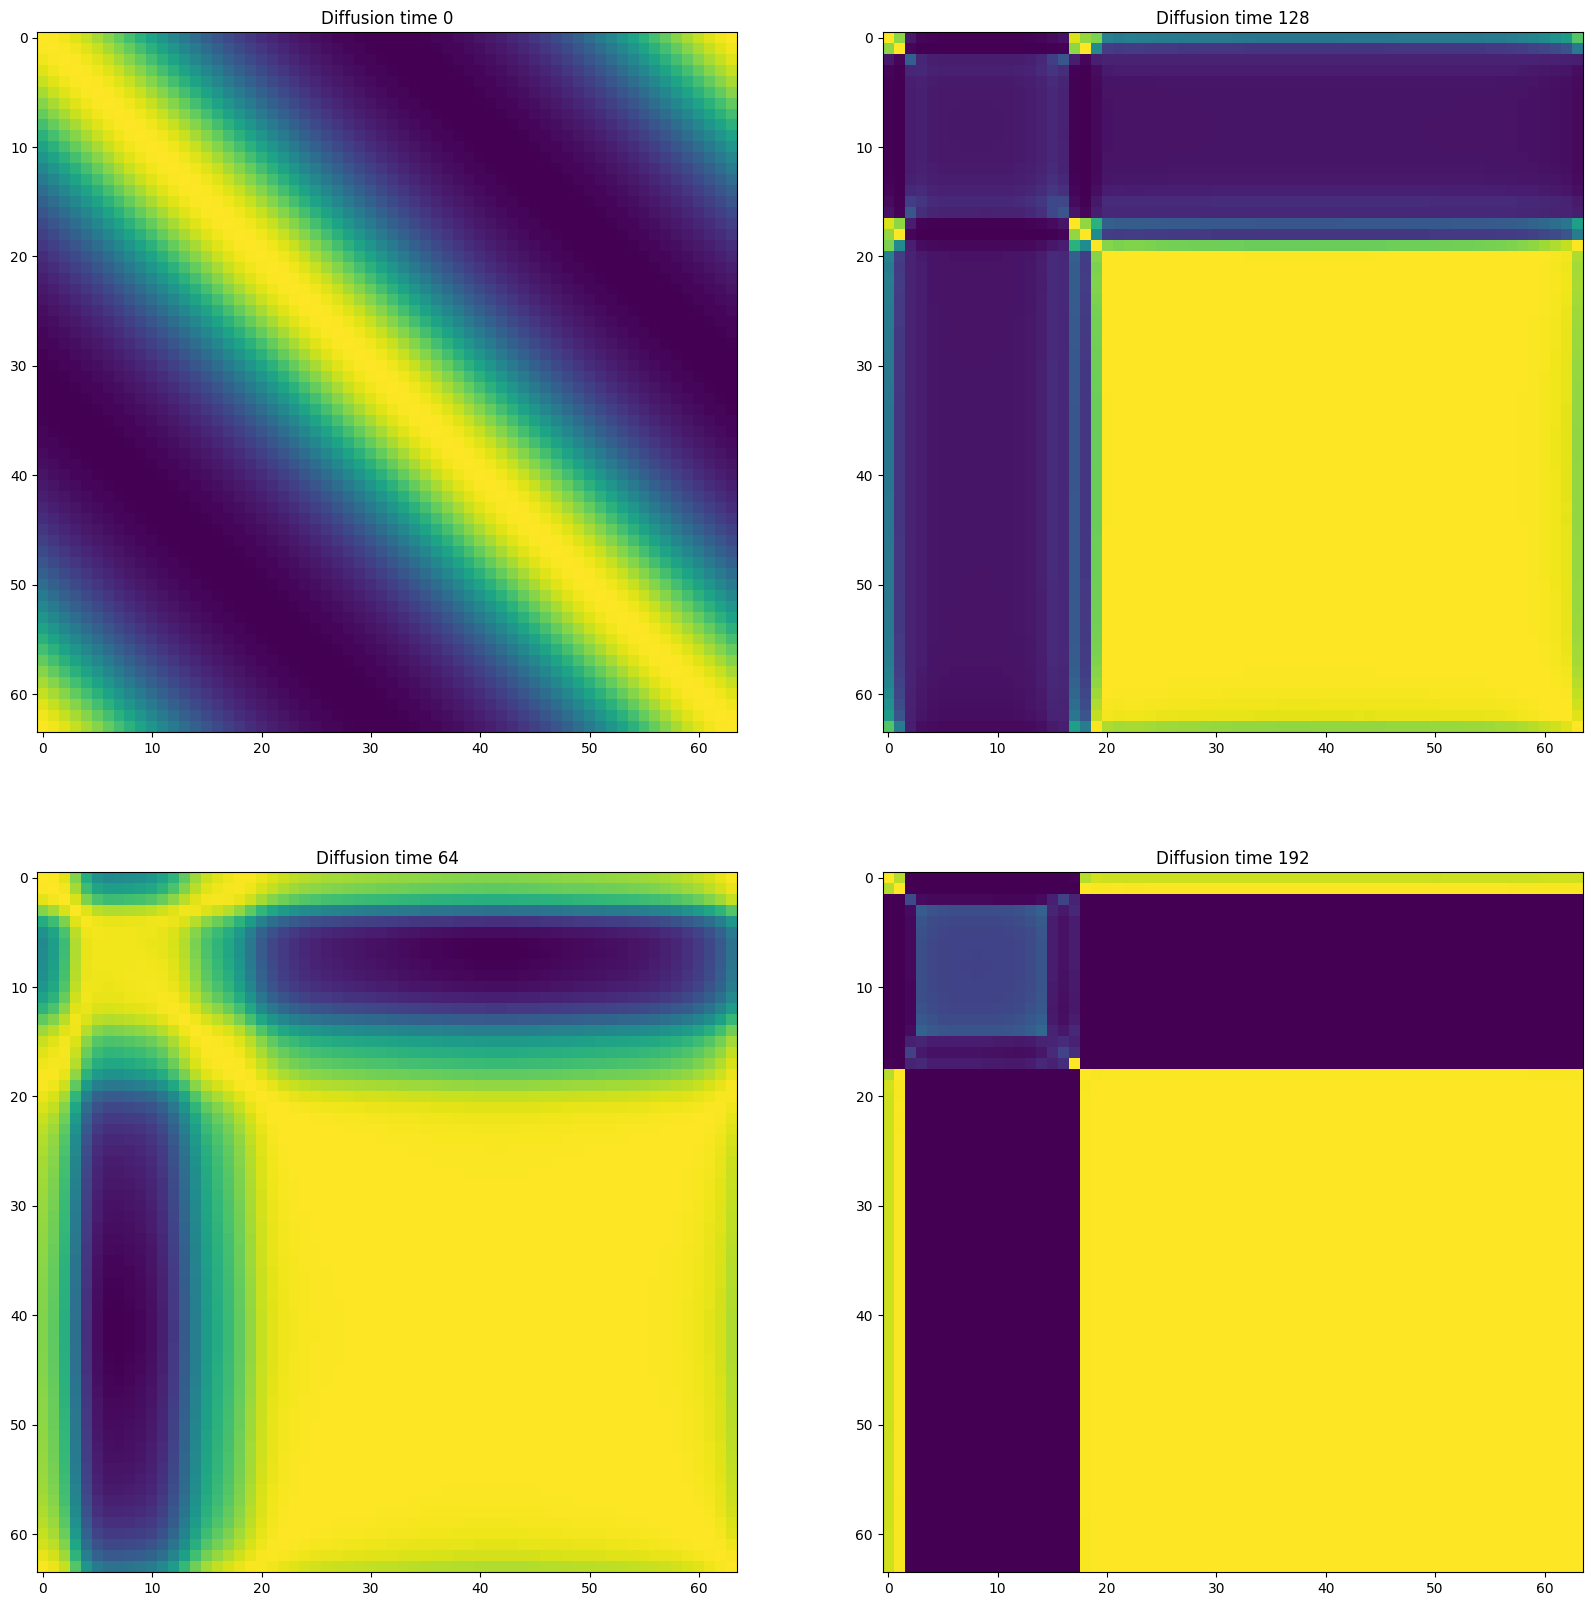

In [8]:

noise_size = 16
Kunita_flow_Eulerian = Kunita_Eulerian_SDE(sigma, kappa, 2, noise_size,(-3,3))
sde_solver = EulerMaruyama.from_sde(Kunita_flow_Eulerian, circle_x0, total_time/time_steps, total_time, noise_size**2, key_gen()) 
training_data_eulerian, diffusion_history_eulerian = sde_solver.solve()
print(diffusion_history_eulerian.shape)
plot_trajectory_2d(training_data_eulerian, "Kunita Flow Eulerian"+" batch_size: "+str(batch_size)+" kappa: "+str(kappa)+" sigma: "+str(sigma) + " noise_size: "+str(noise_size))
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,20))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(jnp.linalg.matmul(diffusion_history_eulerian[time_steps*(i+j*2)//4], diffusion_history_eulerian[time_steps*(i+j*2)//4].T))
        ax[i,j].set_title("Diffusion time "+str(time_steps*(i+j*2)//4))
        # for k in range(batch_size):
        #     for l in range(noise_size ** 2):
        #         # use the scientific notation for the text
        #         ax[i,j].text(l, k, str("{:.2e}".format(diffusion_history[time_steps*(i+j*2)//4][k,l])), color='w', ha='center', va='center', fontsize=6)


plt.show()




### 5.1 Score matching for Kunita Flow


In [9]:
model = AdvancedScoreNet()
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)
@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_Kunita(key, state, sigma, batch_size, time_steps, dim):
    key, subkey = jrandom.split(key)
    noise_size = 32
    radius = 1
    circle_x0 = generate_circle_data(batch_size, radius)
    Kunita_flow_Eulerian = Kunita_Eulerian_SDE(sigma, kappa, 2, noise_size,(-5,5))
    sde_solver = EulerMaruyama.from_sde(Kunita_flow_Eulerian, circle_x0, total_time/time_steps, total_time, noise_size**2, key_gen()) 
    training_data_eulerian, diffusion_history_eulerian = sde_solver.solve()
    Brownian_SDE = Brownian_Motion_SDE(dim, sigma)
    sde_solver = EulerMaruyama.from_sde(Brownian_SDE, circle_x0, total_time/time_steps, total_time, batch_size, key_gen()) 
    training_data_brownian, diffusion_history_brownian = sde_solver.solve()
    t = jnp.array([0.0])
    ts = jnp.linspace(0, 1, time_steps)
    dt = total_time/ time_steps
    x0s = jnp.zeros((batch_size, dim))
    x0s = jnp.expand_dims(x0s, axis=0)
    x0s = jnp.repeat(x0s, time_steps, axis=0)
    xs_noiseds = training_data_eulerian[1:, :, :]
    xs_originals = training_data_eulerian[:-1, :, :]
    
    def total_loss(params):
        def one_step_dsm(xs_original, xs_noised, t):
            def loss_for_one_x(x_original, x_noised, t):
                Sigma_one = Kunita_flow_Eulerian.Sigma()(x_original, t-dt)
                Sigma_current_one = Kunita_flow_Eulerian.Sigma()(x_noised, t)
                Sigma_current_one = Sigma_current_one + 1e-6 * jnp.eye(Sigma_current_one.shape[0])
                Sigma_one = Sigma_one + 1e-6 * jnp.eye(Sigma_one.shape[0])
                pred = state.apply_fn(params, x_noised, t, dim)
                print(pred.shape)
                print(Sigma_current_one.shape)
                print(x_original.shape)
                print(x_noised.shape)
                print(dt)
                true = -jnp.linalg.inv(Sigma_one) @ (x_noised - x_original - dt * Kunita_flow_Eulerian.drift_fn()(x_original, t-dt)) / dt
                print(true.shape)
                return jnp.sqrt((pred-true).T @ Sigma_current_one @ (pred-true))
            return jnp.mean(jax.vmap(loss_for_one_x, in_axes=(0, 0, None))(xs_original, xs_noised, t))
        return jnp.sum(jax.vmap(one_step_dsm, in_axes=(0, 0, 0))(xs_originals, xs_noiseds, ts))
    loss, grad = jax.value_and_grad(total_loss)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss, key

losses = []
for i in tqdm.trange(5000, file=sys.stdout):
    subkey = key_gen()
    state, loss, key = update_step_Kunita(subkey, state, sigma, batch_size, time_steps, dim)
    globe_key = key
    losses.append(loss)
    if i % 1000 == 0:
        tqdm.tqdm.write(f"Loss: {loss}")



score_fn = jax.vmap(lambda x, t: state.apply_fn(state.params, x, t, dim), in_axes=(0, None))
print(score_fn(circle_x0, 0).shape)
print(Kunita_flow_Eulerian.div_Sigma()(circle_x0, 0).shape)
print(Kunita_flow_Eulerian.Sigma()(circle_x0, 0).shape)
print(Kunita_flow_Eulerian.drift_fn()(circle_x0, 0))

reversed_sde_kunita = Time_Reversed_SDE(Kunita_flow_Eulerian, score_fn, total_time)
# reversed_sde_kunita = Time_Reversed_SDE(Kunita_flow_Lagrangian, score_fn, total_time)
# reversed_sde_kunita = Time_Reversed_SDE(Brownian_SDE, score_fn, total_time)

        

  0%|          | 0/5000 [00:00<?, ?it/s]Traced<ShapedArray(float32[256])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[256])>with<DynamicJaxprTrace(level=1/0)>
(2,)
(2, 2)
(2,)
(2,)
0.00390625
(2,)
  0%|          | 0/5000 [00:00<?, ?it/s]


KeyboardInterrupt: 

(64, 2)
(257, 64, 2)


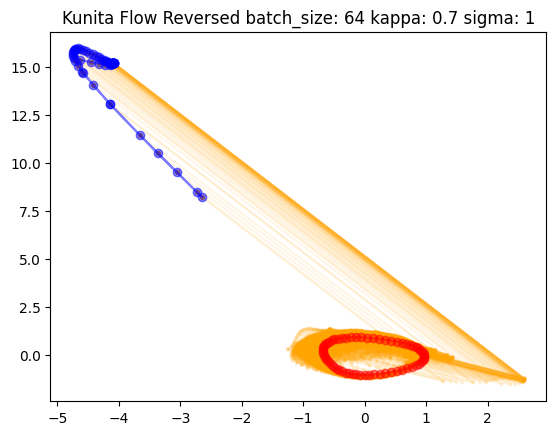

In [39]:
print(training_data_brownian[-1].shape)
sde_solver = EulerMaruyama.from_sde(reversed_sde_kunita, training_data_eulerian[-1], total_time/time_steps, total_time, noise_size**2, key_gen()) 
# Brownian_SDE = Brownian_Motion_SDE(dim, sigma)
# sde_solver = EulerMaruyama.from_sde(reversed_sde_kunita, training_data_brownian[-1], total_time/time_steps, total_time, batch_size, key_gen()) 

training_data_reversed, diffusion_history_reversed = sde_solver.solve()
print(training_data_reversed.shape)
plot_trajectory_2d(training_data_reversed, "Kunita Flow Reversed"+" batch_size: "+str(batch_size)+" kappa: "+str(kappa)+" sigma: "+str(sigma))


# 6 Bridge SDE Simulation
## 6.1 Brownian Bridge